# Mahalanobis distance for outlier detection

In [573]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import random
from sklearn import datasets
import math
import time
import progressbar
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis as mh
from sklearn.covariance import EmpiricalCovariance
import scipy.spatial.distance as distance
from scipy.stats import chi2
from sklearn.covariance import MinCovDet as MCD
import scipy.stats as stats
from scipy.stats import chisquare
import scipy
from scipy.stats import chi2
from statsmodels.stats import gof
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp

On se propose de chercher des éventuels outliers dans les données. Pour cela on va utiliser la distance de Mahalanobis. On se base sur le principe suivnt : si $X \sim \mathbb{N} (\mu,\Sigma)$ alors $D^{2}(X,\mu) \sim \chi^{2}_{p}$.

On peut donc avoir un intervalle de confiance de tel sorte que $\mathbb{P}[D^{2}(X,\mu) \leq \chi^{2}_{p,1-\alpha}] \leq 1-\alpha$

## On Iris

In [52]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names
Xreduced=X[:,0:2]
#Xreduced=preprocessing.MinMaxScaler().fit_transform(Xreduced)
outliers=[]
outliers.append([5,2.5])
outliers.append([8,5])
outliers.append([4,1.5])
outliers.append([6,3])
outliers.append([7,1.5])

Xreduced2=np.append(Xreduced,outliers,axis=0)

d:\Users\S37283\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


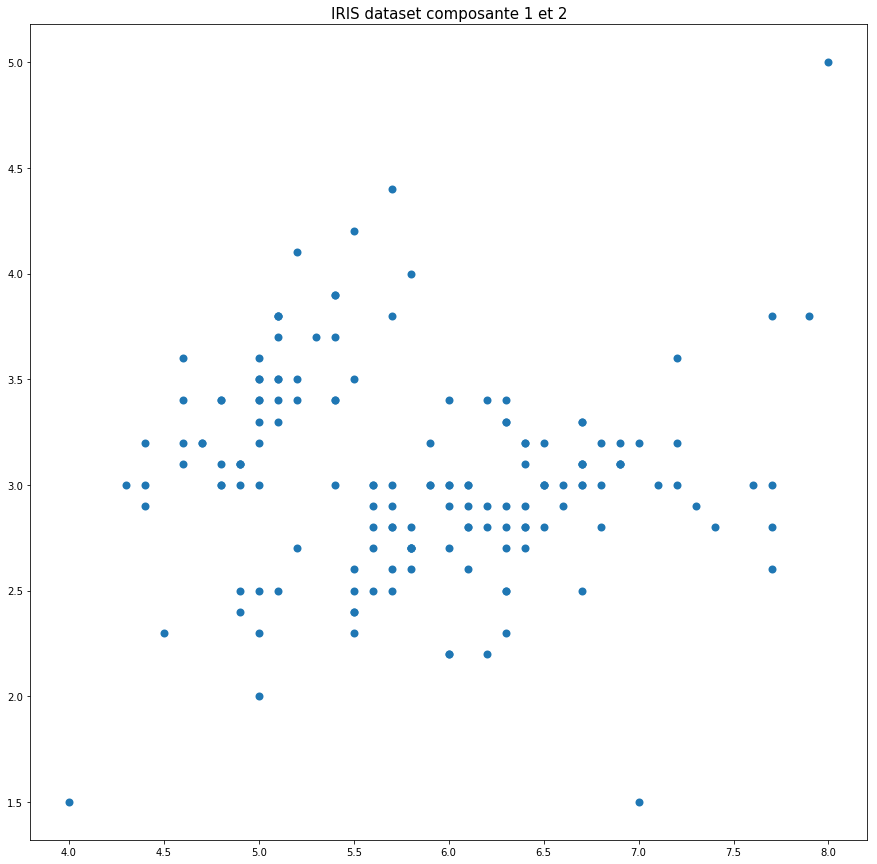

In [53]:
plt.figure(figsize=(15,15))
lw = 2
plt.scatter(Xreduced2[:, 0], Xreduced2[:, 1], lw=lw)
plt.legend(loc='best', shadow=False, scatterpoints=1,fontsize=15)
plt.title('IRIS dataset composante 1 et 2',fontsize=15)
plt.show()

In [171]:
Xreduced_scaled=StandardScaler().fit_transform(Xreduced2)
X=preprocessing.MinMaxScaler().fit_transform(Xreduced_scaled)

In [801]:
class OutlierMahalanobis(object):

    def __init__(self, support_fraction = 0.95, verbose = True, chi2_percentile = 0.995,qqplot=True):
        self.verbose = verbose
        self.support_fraction = support_fraction
        self.chi2 = stats.chi2
        self.mcd = MCD(store_precision = True, support_fraction = support_fraction)
        self.chi2_percentile = chi2_percentile
        self.qqplot=qqplot
        
    def fit(self, X):
        """Prints some summary stats (if verbose is one) and returns the indices of what it consider to be extreme"""
        self.mcd.fit(X)
        d = np.array([distance.mahalanobis(p, self.mcd.location_, self.mcd.precision_ ) for p in X])
        self.d2 = d**2 #MD squared
        n, self.degrees_of_freedom_ = X.shape
        self.iextreme_values = (self.d2 > self.chi2.ppf(self.chi2_percentile, self.degrees_of_freedom_) )
        if self.verbose:
            print("%.3f proportion of outliers at %.3f%% chi2 percentile, "%(self.iextreme_values.sum()/float(n), self.chi2_percentile))
            print("with support fraction %.2f."%self.support_fraction)
            pvalue=stats.kstest(self.d2, lambda x : stats.chi2.cdf(x,df=self.degrees_of_freedom_))[1]
            if pvalue <= 0.01:
                print('Attention : Très forte présomption contre l\'hypothèse nulle p_value : '+str(pvalue))
            elif pvalue <= 0.05:
                print('Attention : Forte présomption contre l\'hypothèse nulle p_value : '+str(pvalue))
            elif pvalue <= 0.1:
                print('Faible présomption contre l\'hypothèse nulle p_value : '+str(pvalue))
            else :
                print('Pas de présomption contre l\'hypothèse nulle. p_value : '+str(pvalue))
            if self.qqplot==True :
                plt.figure(figsize=(10,10))
                stats.probplot(self.d2,dist=stats.chi2(df=self.degrees_of_freedom_), plot=plt)
                plt.title('QQ plot between Mahanalobis distance quantiles and Chi2 quantiles')
                plt.show()
                
        return self

    def plot(self,log=False, sort = False ):
        """
        Cause plotting is always fun.
        
        log: transform the distance-sq to a log ( distance-sq )
        sort: sort the data according to distnace before plotting
        ifollow: a set if indices to mark with yellow, useful for seeing where data lies across views.
        
        """
        n = self.d2.shape[0]
        fig = plt.figure(figsize=(10,10))
        
        x = np.arange( n )
        ax = fig.add_subplot(111)
 
 
        transform = (lambda x: x ) if not log else (lambda x: np.log(x))
        chi_line = self.chi2.ppf(self.chi2_percentile, self.degrees_of_freedom_)     
        
        chi_line = transform( chi_line )
        d2 = transform( self.d2 )
        if sort:
            isort = np.argsort( d2 )    
            ax.scatter(x, d2[isort], alpha = 0.7, facecolors='none' )
            plt.plot( x, transform(self.chi2.ppf( np.linspace(0,1,n),self.degrees_of_freedom_ )), c="r", label="distribution assuming normal" )
            
        
        else:
            ax.scatter(x, d2 )
            extreme_values = d2[ self.iextreme_values ]
            ax.scatter( x[self.iextreme_values], extreme_values, color="r" )
            
        ax.hlines( chi_line, 0, n, 
                        label ="%.1f%% $\chi^2$ quantile"%(100*self.chi2_percentile), linestyles = "dotted" )

        ax.legend()
        ax.set_ylabel("distance squared")
        ax.set_xlabel("observation")
        ax.set_xlim(0, self.d2.shape[0])


        plt.show()


0.077 proportion of outliers at 0.950% chi2 percentile, 
with support fraction 0.95.
Attention : Forte présomption contre l'hypothèse nulle p_value : 0.0159832863143


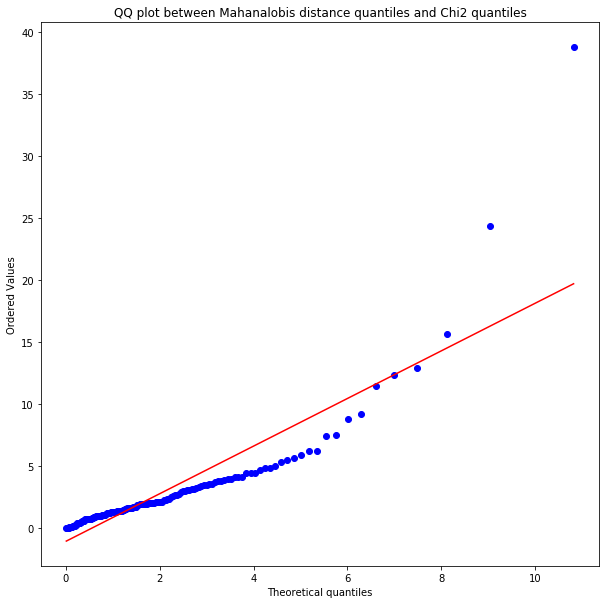

In [804]:
mh=OutlierMahalanobis(support_fraction = 0.95, chi2_percentile = 0.95)
fitmh=mh.fit(X)

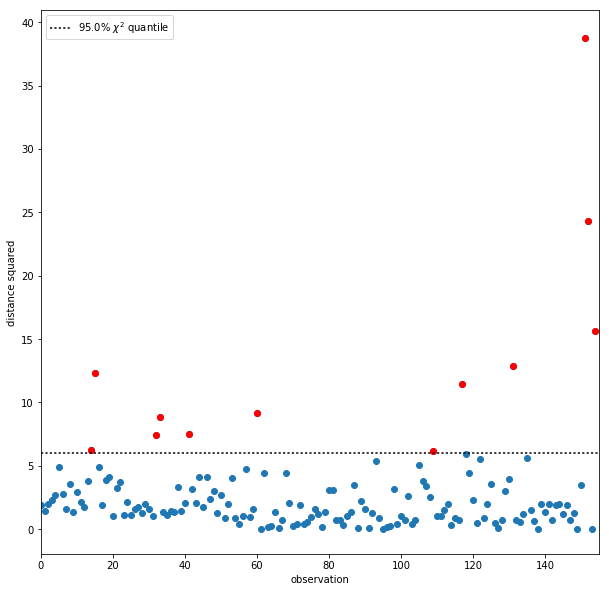

In [805]:
fitmh.plot()

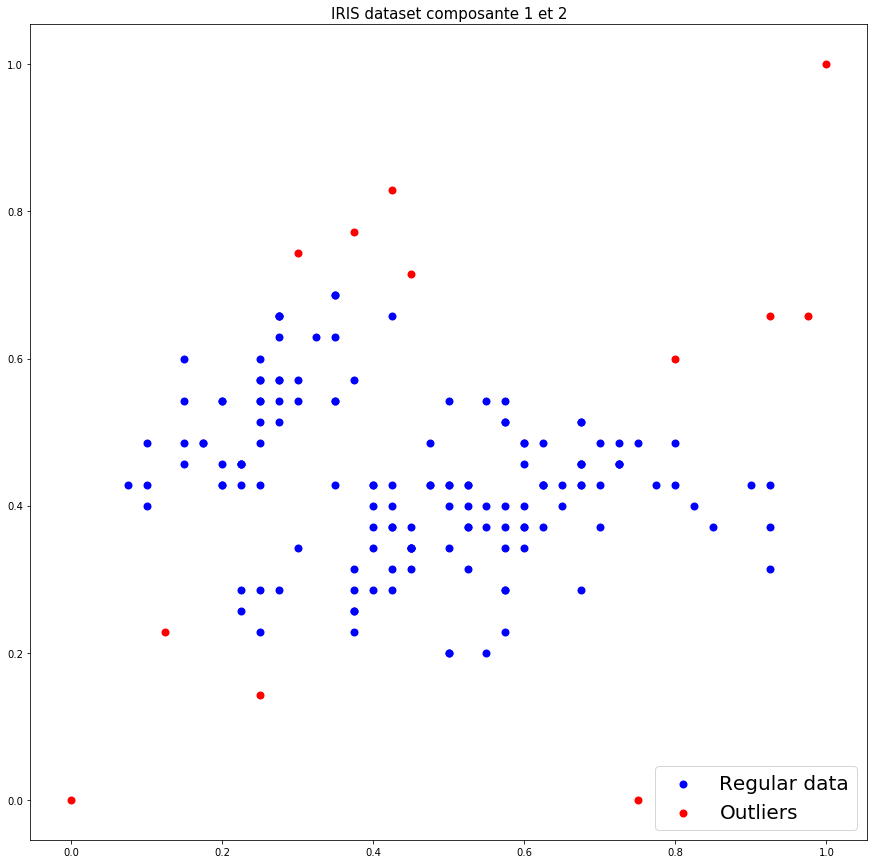

In [806]:
fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
lw = 2
p2=plt.scatter(X[fitmh.iextreme_values, 0], X[fitmh.iextreme_values, 1], lw=lw,color='red')
p1=plt.scatter(X[~fitmh.iextreme_values, 0], X[~fitmh.iextreme_values, 1], lw=lw,color='blue')
plt.title('IRIS dataset composante 1 et 2',fontsize=15)
ax.legend([p1,p2], ["Regular data","Outliers"],fontsize=20,loc=4)
plt.show()

Il correspondent bien aux outliers qu'on a rajouté

## On decisionnel

In [186]:
path_images = 'D:\\Users\\S37283\\Documents\\Outlier detection'
header=['idcli_horus', 'topCSPplus', 'revenu', 'gold', 'topstpub', 'top_in', 'top_out', 'prodres_T1', 'prodamo_T1', 'prod_T1', 'top_port', 'top_fixe', 'emailvalide', 'validemail', 'ancclient', 'derprod_arch', 'cli_actif', 'cli_inactif', 'top_homme', 'top_femme', 'habit_prop', 'habit_loc', 'habit_aut', 'csp_actif', 'csp_inact', 'csp_sup', 'csp_ret', 'csp_emp', 'csp_ouv', 'csp_resp', 'sitfam_C', 'sitfam_M', 'sitfam_D', 'sitfam_U', 'sitfam_V', 'sitfam_S', 'sitfam_DS', 'sitfam_DSV', 'sitfam_MU', 'agiopb12m', 'agiovac12m', 'agiorccc12m', 'agiorccl12m', 'agiopb6m', 'agiovac6m', 'agiorccc6m', 'agiorccl6m', 'encpb_m1', 'encvac_m1', 'encrccc_m1', 'encrccl_m1', 'encleas_m1', 'disporccl_m1', 'encpb_m2', 'encvac_m2', 'encrccc_m2', 'encrccl_m2', 'encleas_m2', 'disporccc_m2', 'disporccl_m2', 'encpb_m3', 'encvac_m3', 'encrccc_m3', 'encrccl_m3', 'encleas_m3', 'disporccc_m3', 'disporccl_m3', 'encpb_m4', 'encvac_m4', 'encrccc_m4', 'encrccl_m4', 'encleas_m4', 'disporccc_m4', 'disporccl_m4', 'encpb_m5', 'encvac_m5', 'encrccc_m5', 'encrccl_m5', 'encleas_m5', 'disporccc_m5', 'disporccl_m5', 'encpb_m6', 'encvac_m6', 'encrccc_m6', 'encrccl_m6', 'encleas_m6', 'disporccc_m6', 'disporccl_m6', 'encpb_m7', 'encvac_m7', 'encrccc_m7', 'encrccl_m7', 'encleas_m7', 'disporccc_m7', 'disporccl_m7', 'encpb_m8', 'encvac_m8', 'encrccc_m8', 'encrccl_m8', 'encleas_m8', 'disporccc_m8', 'disporccl_m8', 'encpb_m9', 'encvac_m9', 'encrccc_m9', 'encrccl_m9', 'encleas_m9', 'disporccc_m9', 'disporccl_m9', 'encpb_m10', 'encvac_m10', 'encrccc_m10', 'encrccl_m10', 'encleas_m10', 'disporccc_m10', 'disporccl_m10', 'encpb_m11', 'encvac_m11', 'encrccc_m11', 'encrccl_m11', 'encleas_m11', 'disporccc_m11', 'disporccl_m11', 'encpb_m12', 'encvac_m12', 'encrccc_m12', 'encrccl_m12', 'encleas_m12', 'disporccc_m12', 'disporccl_m12', 'agio12m', 'agio6m', 'agioamo12m', 'agioamo6m', 'agiores12m', 'agiores6m', 'enc_m1', 'encamo_m1', 'encres_m1', 'dispo_m1', 'enc_m2', 'encamo_m2', 'encres_m2', 'dispo_m2', 'enc_m3', 'encamo_m3', 'encres_m3', 'dispo_m3', 'enc_m4', 'encamo_m4', 'encres_m4', 'dispo_m4', 'enc_m5', 'encamo_m5', 'encres_m5', 'dispo_m5', 'enc_m6', 'encamo_m6', 'encres_m6', 'dispo_m6', 'enc_m7', 'encamo_m7', 'encres_m7', 'dispo_m7', 'enc_m8', 'encamo_m8', 'encres_m8', 'dispo_m8', 'enc_m9', 'encamo_m9', 'encres_m9', 'dispo_m9', 'enc_m10', 'encamo_m10', 'encres_m10', 'dispo_m10', 'enc_m11', 'encamo_m11', 'encres_m11', 'dispo_m11', 'enc_m12', 'encamo_m12', 'encres_m12', 'dispo_m12', 'nbmenc12M', 'nbmenc6M', 'nbmencamo12M', 'nbmencamo6M', 'nbmencres12M', 'nbmencres6M', 'nbmdispo12M', 'nbmdispo6M', 'senc12M', 'senc6M', 'sencamo12M', 'sencamo6M', 'sencpb12M', 'sencpb6M', 'sencvac12M', 'sencvac6M', 'sencres12M', 'sencres6M', 'sencrccc12M', 'sencrccc6M', 'sencrccl12M', 'sencrccl6M', 'sdispo12M', 'sdispo6M', 'sdisporccc12M', 'sdisporccc6M', 'sdisporccl12M', 'sdisporccl6M', 'moyenc12M', 'moyencamo12M', 'moyencpb12M', 'moyencvac12M', 'moyencres12M', 'moyencrccc12M', 'moyencrccl12M', 'moydispo12M', 'moydisporccc12M', 'moydisporccl12M', 'moyenc6M', 'moyencamo6M', 'moyencpb6M', 'moyencvac6M', 'moyencres6M', 'moyencrccc6M', 'moyencrccl6M', 'moydispo6M', 'moydisporccc6M', 'moydisporccl6M', 'agiopb_m1', 'agiovac_m1', 'agiorccc_m1', 'agiorccl_m1', 'agiopb_m2', 'agiovac_m2', 'agiorccc_m2', 'agiorccl_m2', 'agiopb_m3', 'agiovac_m3', 'agiorccc_m3', 'agiorccl_m3', 'agiopb_m4', 'agiovac_m4', 'agiorccc_m4', 'agiorccl_m4', 'agiopb_m5', 'agiovac_m5', 'agiorccc_m5', 'agiorccl_m5', 'agiopb_m6', 'agiovac_m6', 'agiorccc_m6', 'agiorccl_m6', 'agiopb_m7', 'agiovac_m7', 'agiorccc_m7', 'agiorccl_m7', 'agiopb_m8', 'agiovac_m8', 'agiorccc_m8', 'agiorccl_m8', 'agiopb_m9', 'agiovac_m9', 'agiorccc_m9', 'agiorccl_m9', 'agiopb_m10', 'agiovac_m10', 'agiorccc_m10', 'agiorccl_m10', 'agiopb_m11', 'agiovac_m11', 'agiorccc_m11', 'agiorccl_m11', 'agiopb_m12', 'agiovac_m12', 'agiorccc_m12', 'agiorccl_m12', 'agio_m1', 'agioamo_m1', 'agiores_m1', 'agio_m2', 'agioamo_m2', 'agiores_m2', 'agio_m3', 'agioamo_m3', 'agiores_m3', 'agio_m4', 'agioamo_m4', 'agiores_m4', 'agio_m5', 'agioamo_m5', 'agiores_m5', 'agio_m6', 'agioamo_m6', 'agiores_m6', 'agio_m7', 'agioamo_m7', 'agiores_m7', 'agio_m8', 'agioamo_m8', 'agiores_m8', 'agio_m9', 'agioamo_m9', 'agiores_m9', 'agio_m10', 'agioamo_m10', 'agiores_m10', 'agio_m11', 'agioamo_m11', 'agiores_m11', 'agio_m12', 'agioamo_m12', 'agiores_m12', 'nbmagio12M', 'nbmagio6M', 'nbmagioamo12M', 'nbmagioamo6M', 'nbmagiores12M', 'nbmagiores6M', 'minagio6M', 'minagio12M', 'maxagio6M', 'maxagio12M', 'minagiopb6M', 'minagiopb12M', 'maxagiopb6M', 'maxagiopb12M', 'minagiovac6M', 'minagiovac12M', 'maxagiovac6M', 'maxagiovac12M', 'minagiorccc6M', 'minagiorccc12M', 'maxagiorccc6M', 'maxagiorccc12M', 'minagiorccl6M', 'minagiorccl12M', 'maxagiorccl6M', 'maxagiorccl12M', 'minagioamo6M', 'minagioamo12M', 'maxagioamo6M', 'maxagioamo12M', 'minagiores6M', 'minagiores12M', 'maxagiores6M', 'maxagiores12M', 'minenc6M', 'minenc12M', 'maxenc6M', 'maxenc12M', 'minencpb6M', 'minencpb12M', 'maxencpb6M', 'maxencpb12M', 'minencvac6M', 'minencvac12M', 'maxencvac6M', 'maxencvac12M', 'minencrccc6M', 'minencrccc12M', 'maxencrccc6M', 'maxencrccc12M', 'minencrccl6M', 'minencrccl12M', 'maxencrccl6M', 'maxencrccl12M', 'minencamo6M', 'minencamo12M', 'maxencamo6M', 'maxencamo12M', 'minencres6M', 'minencres12M', 'maxencres6M', 'maxencres12M', 'mindispo6M', 'mindispo12M', 'maxdispo6M', 'maxdispo12M', 'maxdisporccc6M', 'maxdisporccc12M', 'mindisporccl6M', 'mindisporccl12M', 'maxdisporccl6M', 'maxdisporccl12M', 'nbpb', 'nbvac', 'nbleas', 'nbrccc', 'nbrccl', 'nbpbarc', 'nbvacarc', 'nbleasarc', 'nbrcccarc', 'nbrcclarc', 'nbpbnarc', 'nbvacnarc', 'nbleasnarc', 'nbrcccnarc', 'nbrcclnarc', 'toppb', 'topvac', 'topleas', 'toprccc', 'toppbarc', 'topvacarc', 'topleasarc', 'toprcccarc', 'toprcclarc', 'toppbnarc', 'topvacnarc', 'topleasnarc', 'toprcccnarc', 'toprcclnarc', 'nbdemat', 'nbdematarc', 'nbdematnarc', 'topdemat', 'topdematarc', 'topdematnarc', 'nbcpthl', 'nbcptl', 'nbamo', 'nbres', 'nbcpthlarc', 'nbcptlarc', 'nbamoarc', 'nbresarc', 'nbcpthlnarc', 'nbcptlnarc', 'nbamonarc', 'nbresnarc', 'topamo', 'topamoarc', 'topresarc', 'topamonarc', 'topresnarc', 'mtpb', 'mtvac', 'mtrccc', 'mtrccl', 'mtpbarc', 'mtvacarc', 'mtrcccarc', 'mtrcclarc', 'mtpbnarc', 'mtvacnarc', 'mtrcccnarc', 'mtrcclnarc', 'mtamo', 'mtres', 'mtamoarc', 'mtresarc', 'mtamonarc', 'mtresnarc', 'mtminpb', 'mtminvac', 'mtminrccc', 'mtminrccl', 'mtmaxpb', 'mtmaxvac', 'mtmaxrccc', 'mtmaxrccl', 'mtminamo', 'mtminres', 'mtmaxamo', 'mtmaxres', 'recderpb', 'recdervac', 'recderrccc', 'recderrccl', 'recdarcpb', 'recdarcvac', 'recdarcrccc', 'recdarcrccl', 'recdercpt', 'recderamo', 'recderres', 'recdarccpt', 'recdarcamo', 'recdarcres', 'nbsoll_m1', 'nbsmail_m1', 'nbsemail_m1', 'nbsas_m1', 'nbsanim_m1', 'nbscross_m1', 'nbsoll_m2', 'nbsmail_m2', 'nbsemail_m2', 'nbsas_m2', 'nbsanim_m2', 'nbscross_m2', 'nbsoll_m3', 'nbsmail_m3', 'nbsemail_m3', 'nbsas_m3', 'nbsanim_m3', 'nbscross_m3', 'nbsoll_m4', 'nbsmail_m4', 'nbsemail_m4', 'nbsas_m4', 'nbsanim_m4', 'nbscross_m4', 'nbsoll_m5', 'nbsmail_m5', 'nbsemail_m5', 'nbsas_m5', 'nbsanim_m5', 'nbscross_m5', 'nbsoll_m6', 'nbsmail_m6', 'nbsemail_m6', 'nbsas_m6', 'nbsanim_m6', 'nbscross_m6', 'nbsoll_m7', 'nbsmail_m7', 'nbsemail_m7', 'nbsas_m7', 'nbsanim_m7', 'nbscross_m7', 'nbsoll_m8', 'nbsmail_m8', 'nbsemail_m8', 'nbsas_m8', 'nbsanim_m8', 'nbscross_m8', 'nbsoll_m9', 'nbsmail_m9', 'nbsemail_m9', 'nbsas_m9', 'nbsanim_m9', 'nbscross_m9', 'nbsoll_m10', 'nbsmail_m10', 'nbsemail_m10', 'nbsas_m10', 'nbsanim_m10', 'nbscross_m10', 'nbsoll_m11', 'nbsmail_m11', 'nbsemail_m11', 'nbsas_m11', 'nbsanim_m11', 'nbscross_m11', 'nbmsoll12M', 'nbmsoll6M', 'nbmsoll3M', 'nbmsmail12M', 'nbmsmail6M', 'nbmsmail3M', 'nbmsemail12M', 'nbmsemail6M', 'nbmsemail3M', 'nbmssms12M', 'nbmssms6M', 'nbmssms3M', 'nbmsas12M', 'nbmsas6M', 'nbmsas3M', 'nbmsanim12M', 'nbmsanim6M', 'nbmsanim3M', 'nbmscross12M', 'nbmscross6M', 'nbmscross3M', 'nbsoll3M', 'nbsoll6M', 'nbsoll12M', 'nbsanim3M', 'nbsanim6M', 'nbsanim12M', 'nbscross3M', 'nbscross6M', 'nbscross12M', 'nbsmail3M', 'nbsmail6M', 'nbsmail12M', 'nbsemail3M', 'nbsemail6M', 'nbsemail12M', 'nbssms3M', 'nbssms6M', 'nbssms12M', 'nbsas3M', 'nbsas6M', 'nbsas12M', 'maxnbsoll3M', 'maxnbsoll6M', 'maxnbsoll12M', 'minnbsoll3M', 'minnbsoll6M', 'maxnbsanim3M', 'maxnbsanim6M', 'maxnbsanim12M', 'minnbsanim3M', 'minnbsanim6M', 'maxnbscross3M', 'maxnbscross6M', 'maxnbscross12M', 'minnbscross3M', 'minnbscross6M', 'maxnbsmail3M', 'maxnbsmail6M', 'maxnbsmail12M', 'minnbsmail3M', 'minnbsmail6M', 'maxnbsemail3M', 'maxnbsemail6M', 'maxnbsemail12M', 'minnbsemail3M', 'minnbsemail6M', 'nbae_m1', 'nbaeds_m1', 'nbaems_m1', 'nbaefs_m1', 'nbaeam_m1', 'nbaepm_m1', 'nbae_m2', 'nbaeds_m2', 'nbaems_m2', 'nbaefs_m2', 'nbaeam_m2', 'nbaepm_m2', 'nbae_m3', 'nbaeds_m3', 'nbaems_m3', 'nbaefs_m3', 'nbaeam_m3', 'nbaepm_m3', 'nbae_m4', 'nbaeds_m4', 'nbaems_m4', 'nbaefs_m4', 'nbaeam_m4', 'nbaepm_m4', 'nbae_m5', 'nbaeds_m5', 'nbaems_m5', 'nbaefs_m5', 'nbaeam_m5', 'nbaepm_m5', 'nbae_m6', 'nbaeds_m6', 'nbaems_m6', 'nbaefs_m6', 'nbaeam_m6', 'nbaepm_m6', 'nbae_m7', 'nbaeds_m7', 'nbaems_m7', 'nbaefs_m7', 'nbaeam_m7', 'nbaepm_m7', 'nbae_m8', 'nbaeds_m8', 'nbaems_m8', 'nbaefs_m8', 'nbaeam_m8', 'nbaepm_m8', 'nbae_m9', 'nbaeds_m9', 'nbaems_m9', 'nbaefs_m9', 'nbaeam_m9', 'nbaepm_m9', 'nbae_m10', 'nbaeds_m10', 'nbaems_m10', 'nbaefs_m10', 'nbaeam_m10', 'nbaepm_m10', 'nbae_m11', 'nbaeds_m11', 'nbaems_m11', 'nbaefs_m11', 'nbaeam_m11', 'nbaepm_m11', 'nbae_m12', 'nbaeds_m12', 'nbaems_m12', 'nbaefs_m12', 'nbaeam_m12', 'nbaepm_m12', 'nbmae12M', 'nbmae6M', 'nbmae3M', 'nbmaeds12M', 'nbmaeds6M', 'nbmaeds3M', 'nbmaems12M', 'nbmaems6M', 'nbmaems3M', 'nbmaefs12M', 'nbmaefs6M', 'nbmaefs3M', 'nbmaeam12M', 'nbmaeam6M', 'nbmaeam3M', 'nbmaepm12M', 'nbmaepm6M', 'nbmaepm3M', 'nbae3M', 'nbae6M', 'nbae12M', 'maxnbae3M', 'maxnbae6M', 'maxnbae12M', 'nbaeds3M', 'nbaeds6M', 'nbaeds12M', 'maxnbaeds3M', 'maxnbaeds6M', 'maxnbaeds12M', 'nbaems3M', 'nbaems6M', 'nbaems12M', 'maxnbaems3M', 'maxnbaems6M', 'maxnbaems12M', 'nbaefs3M', 'nbaefs6M', 'nbaefs12M', 'maxnbaefs3M', 'maxnbaefs6M', 'maxnbaefs12M', 'nbaeam3M', 'nbaeam6M', 'nbaeam12M', 'maxnbaeam3M', 'maxnbaeam6M', 'maxnbaeam12M', 'nbaepm3M', 'nbaepm6M', 'nbaepm12M', 'maxnbaepm3M', 'maxnbaepm6M', 'maxnbaepm12M', 'topA3', 'topB4', 'topB5', 'topF5', 'topF6', 'topM2', 'prodmagrccl_m1', 'prodtresrccl_m1', 'prodcartrccl_m1', 'prodmagres_m1', 'prodtresres_m1', 'prodcartres_m1', 'prodrccl_m1', 'prodres_m1', 'prodmagrccl_m2', 'prodtresrccc_m2', 'prodtresrccl_m2', 'prodcartrccl_m2', 'prodmagres_m2', 'prodtresres_m2', 'prodcartres_m2', 'prodrccc_m2', 'prodrccl_m2', 'prodres_m2', 'prodmagrccc_m3', 'prodmagrccl_m3', 'prodtresrccc_m3', 'prodtresrccl_m3', 'prodcartrccl_m3', 'prodmagres_m3', 'prodtresres_m3', 'prodcartres_m3', 'prodrccc_m3', 'prodrccl_m3', 'prodres_m3', 'prodmagrccl_m4', 'prodtresrccc_m4', 'prodtresrccl_m4', 'prodcartrccl_m4', 'prodmagres_m4', 'prodtresres_m4', 'prodcartres_m4', 'prodrccc_m4', 'prodrccl_m4', 'prodres_m4', 'prodmagrccl_m5', 'prodtresrccc_m5', 'prodtresrccl_m5', 'prodcartrccl_m5', 'prodmagres_m5', 'prodtresres_m5', 'prodcartres_m5', 'prodrccc_m5', 'prodrccl_m5', 'prodres_m5', 'prodmagrccl_m6', 'prodtresrccc_m6', 'prodtresrccl_m6', 'prodcartrccc_m6', 'prodcartrccl_m6', 'prodmagres_m6', 'prodtresres_m6', 'prodcartres_m6', 'prodrccc_m6', 'prodrccl_m6', 'prodres_m6', 'prodmagrccl_m7', 'prodtresrccc_m7', 'prodtresrccl_m7', 'prodcartrccc_m7', 'prodcartrccl_m7', 'prodmagres_m7', 'prodtresres_m7', 'prodcartres_m7', 'prodrccc_m7', 'prodrccl_m7', 'prodres_m7', 'prodmagrccl_m8', 'prodtresrccc_m8', 'prodtresrccl_m8', 'prodcartrccc_m8', 'prodcartrccl_m8', 'prodmagres_m8', 'prodtresres_m8', 'prodcartres_m8', 'prodrccc_m8', 'prodrccl_m8', 'prodres_m8', 'prodmagrccl_m9', 'prodtresrccc_m9', 'prodtresrccl_m9', 'prodcartrccc_m9', 'prodcartrccl_m9', 'prodmagres_m9', 'prodtresres_m9', 'prodcartres_m9', 'prodrccc_m9', 'prodrccl_m9', 'prodres_m9', 'prodmagrccl_m10', 'prodtresrccc_m10', 'prodtresrccl_m10', 'prodcartrccc_m10', 'prodcartrccl_m10', 'prodmagres_m10', 'prodtresres_m10', 'prodcartres_m10', 'prodrccc_m10', 'prodrccl_m10', 'prodres_m10', 'prodmagrccl_m11', 'prodtresrccc_m11', 'prodtresrccl_m11', 'prodcartrccc_m11', 'prodcartrccl_m11', 'prodmagres_m11', 'prodtresres_m11', 'prodcartres_m11', 'prodrccc_m11', 'prodrccl_m11', 'prodres_m11', 'prodmagrccc_m12', 'prodmagrccl_m12', 'prodtresrccc_m12', 'prodtresrccl_m12', 'prodcartrccc_m12', 'prodcartrccl_m12', 'prodmagres_m12', 'prodtresres_m12', 'prodcartres_m12', 'prodrccc_m12', 'prodrccl_m12', 'prodres_m12', 'nbmpres12M', 'nbmpres6M', 'nbmprccc12M', 'nbmprccc6M', 'nbmprccl12M', 'nbmprccl6M', 'nbmpmagres12M', 'nbmpmagres6M', 'nbmptresres12M', 'nbmptresres6M', 'nbmpcartres12M', 'nbmpcartres6M', 'nbmpmagrccc12M', 'nbmpmagrccc6M', 'nbmptresrccc12M', 'nbmptresrccc6M', 'nbmpcartrccc12M', 'nbmpcartrccc6M', 'nbmpmagrccl12M', 'nbmpmagrccl6M', 'nbmptresrccl12M', 'nbmptresrccl6M', 'nbmpcartrccl12M', 'nbmpcartrccl6M', 'spres12M', 'spres6M', 'sprccc12M', 'sprccc6M', 'sprccl12M', 'sprccl6M', 'spmagres12M', 'spmagres6M', 'sptresres12M', 'sptresres6M', 'spcartres12M', 'spcartres6M', 'spmagrccc12M', 'spmagrccc6M', 'sptresrccc12M', 'sptresrccc6M', 'spcartrccc12M', 'spcartrccc6M', 'spmagrccl12M', 'spmagrccl6M', 'sptresrccl12M', 'sptresrccl6M', 'spcartrccl12M', 'spcartrccl6M', 'minprodres6M', 'minprodres12M', 'maxprodres6M', 'maxprodres12M', 'maxprodrccc6M', 'maxprodrccc12M', 'minprodrccl6M', 'minprodrccl12M', 'maxprodrccl6M', 'maxprodrccl12M', 'minprodmagres6M', 'minprodmagres12M', 'maxprodmagres6M', 'maxprodmagres12M', 'maxprodmagrccc6M', 'maxprodmagrccc12M', 'minprodmagrccl6M', 'minprodmagrccl12M', 'maxprodmagrccl6M', 'maxprodmagrccl12M', 'minprodtresres6M', 'minprodtresres12M', 'maxprodtresres6M', 'maxprodtresres12M', 'maxprodtresrccc6M', 'maxprodtresrccc12M', 'minprodtresrccl6M', 'minprodtresrccl12M', 'maxprodtresrccl6M', 'maxprodtresrccl12M', 'minprodcartres6M', 'minprodcartres12M', 'maxprodcartres6M', 'maxprodcartres12M', 'maxprodcartrccc6M', 'maxprodcartrccc12M', 'minprodcartrccl6M', 'minprodcartrccl12M', 'maxprodcartrccl6M', 'maxprodcartrccl12M', 'actif', 'arch1an', 'arch3an', 'arch5an', 'nbckg', 'ckg_actif', 'ckg_1an', 'ckg_anim', 'ckg_3an', 'ckg_5an', 'nbptps', 'ptps_actif', 'ptps_1an', 'ptps_anim', 'ptps_3an', 'ptps_5an', 'nbfnac', 'fnac_actif', 'fnac_1an', 'fnac_anim', 'fnac_3an', 'fnac_5an', 'nblfnac', 'fnac', 'nbrcem', 'rcem_actif', 'rcem_1an', 'rcem_anim', 'rcem_3an', 'rcem_5an', 'nbCC', 'CC_3an', 'CC_5an', 'a_cfpe', 'a_cfp', 'a_cfe', 'a_cpe', 'a_fpe', 'a_cf', 'a_cp', 'a_ce', 'a_fp', 'a_fe', 'a_pe', 'a_c', 'a_f', 'a_p', 'a_e', 'fin']
path='../dtm_cross201606.csv.gz'
store_cible=pd.HDFStore('../PCA/cible_crossB2B.h5')

In [187]:
dfCible=store_cible.select('dfCible')
indices1=np.where(dfCible['fin']==1)[0]

In [188]:
n = 2572345 #number of records in file
s = 200000 #desired sample size
skip = sorted(random.sample(range(n),n-s))

In [189]:
skip2=list(set(range(n)).difference(indices1))
skip3=[x+1 for x in skip2]

In [190]:
df_sample = pd.read_table(path,compression='gzip', sep=';',lineterminator='\n',skiprows=skip)
df_sample2 = pd.read_table(path,compression='gzip', sep=';',lineterminator='\n',skiprows=skip3)
df_sample2.columns=header
df_sample.columns=header

In [191]:
frames= [df_sample,df_sample2]
df= pd.concat(frames)

In [192]:
del df_sample
del df_sample2

In [193]:
df.head()

,idcli_horus,topCSPplus,revenu,gold,topstpub,top_in,top_out,prodres_T1,prodamo_T1,prod_T1,...,a_cp,a_ce,a_fp,a_fe,a_pe,a_c,a_f,a_p,a_e,fin
0,91000344857,0,3400.0,0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,91000419975,0,4000.0,0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,91000492173,1,1793.0,0,0,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,91000568659,1,3014.0,0,1,0,0,1627.0,0.0,1627.0,...,0,0,0,0,0,0,1,0,0,0
4,91000610804,1,4198.0,1,0,0,0,370.0,0.0,370.0,...,0,0,0,0,0,0,0,0,1,0


In [194]:
df=df.fillna(0)

In [195]:
from sklearn.decomposition import PCA

In [196]:
DF=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df),columns=df.columns)
DF=DF.drop('idcli_horus',axis=1)

In [197]:
pca=PCA(n_components=20,svd_solver='arpack')
pca.fit(DF)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='arpack', tol=0.0, whiten=False)

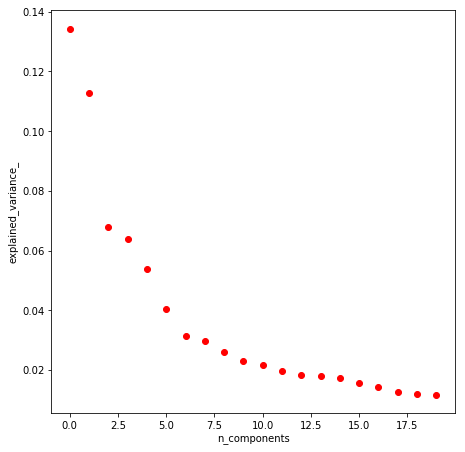

In [198]:
plt.figure(1, figsize=(8, 8))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_,'ro', linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

In [210]:
pca=PCA(n_components=10,svd_solver='arpack')
pca.fit(DF)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='arpack', tol=0.0, whiten=False)

In [211]:
dataset_all=pca.transform(DF)

0.009 proportion of outliers at 0.999% chi2 percentile, 
with support fraction 0.95.
Attention : Très forte présomption contre l'hypothèse nulle p_value : 0.0


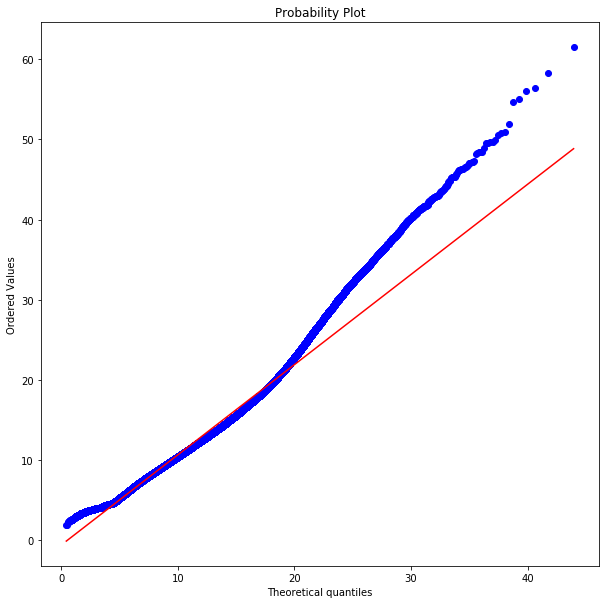

In [790]:
outliersMahanalobis=OutlierMahalanobis(support_fraction = 0.95, chi2_percentile = 0.999)
outliersMahanalobis.fit(dataset_all)

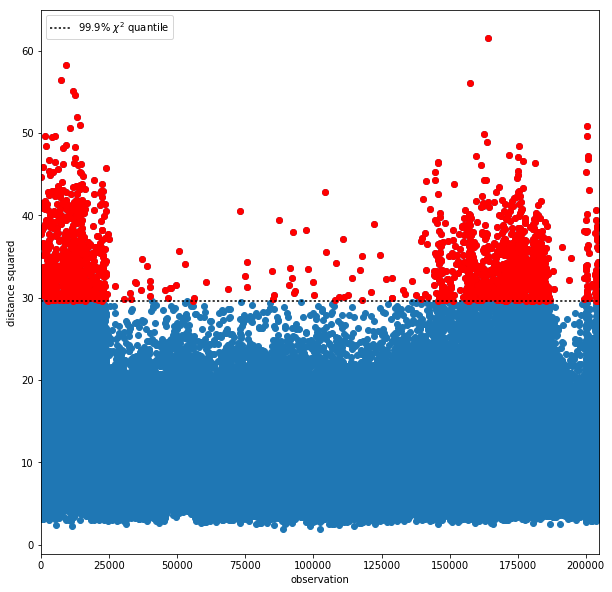

In [772]:
outliersMahanalobis.plot()

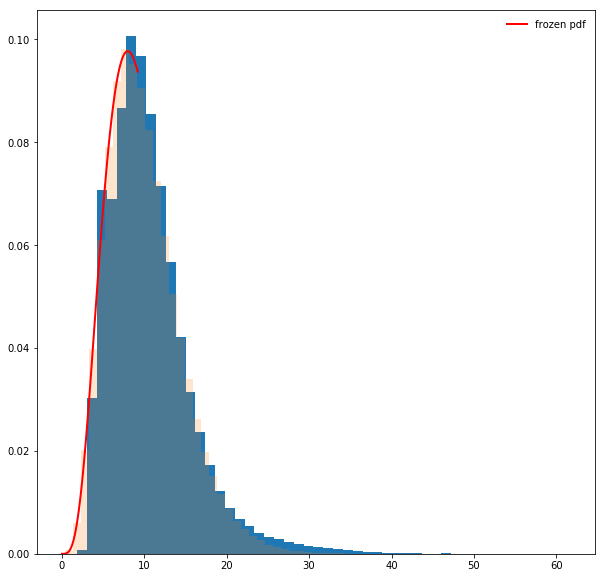

In [744]:
rv = chi2(df=10)
x = np.linspace(chi2.ppf(0.01, df),chi2.ppf(0.99, df), 100)
r = chi2.rvs(df=10, size=len(outliersMahanalobis.d2))
plt.figure(figsize=(10,10))
plt.hist(outliersMahanalobis.d2,bins=50,normed=True)
plt.hist(r ,bins=50,normed=True,alpha=0.2)
plt.plot(x, rv.pdf(x), 'r-', lw=2, label='frozen pdf')
plt.legend(loc='best', frameon=False)
plt.show()

## Sur un dataset qui doit marcher

In [776]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]  # didagonal covariance
data = np.random.multivariate_normal(mean, cov, 5000)

In [777]:
data

array([[ -0.473,  10.428],
       [  0.643,  -1.332],
       [ -0.317,  -7.399],
       ..., 
       [ -0.438,  -3.902],
       [ -0.793,   5.371],
       [  0.978,   3.670]])

0.068 proportion of outliers at 0.950% chi2 percentile, 
with support fraction 0.95.
Attention : Très forte présomption contre l'hypothèse nulle p_value : 3.45971283808e-07


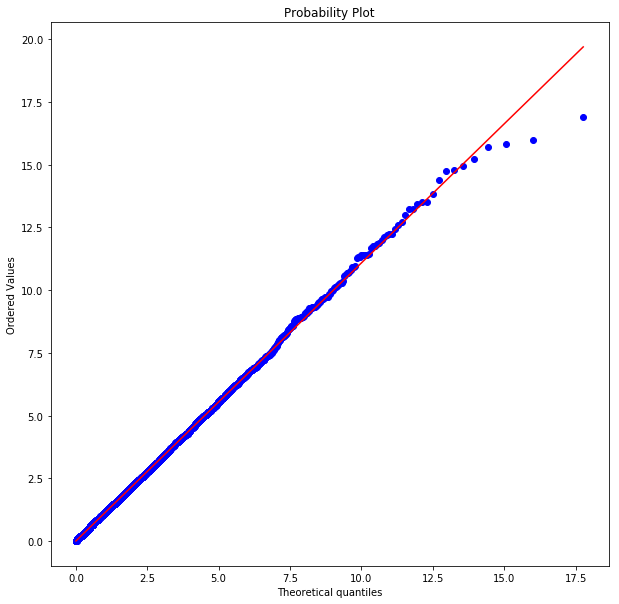

In [778]:
outliersMahanalobis=OutlierMahalanobis(support_fraction = 0.95, chi2_percentile = 0.95)
outliersMahanalobis.fit(data)

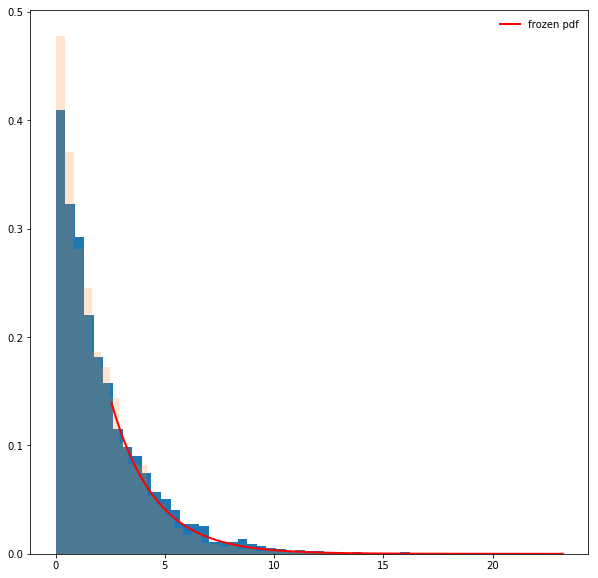

In [750]:
rv = chi2(df=2)
x = np.linspace(chi2.ppf(0.01, df),chi2.ppf(0.99, df), 100)
r = chi2.rvs(df=2, size=len(outliersMahanalobis.d2))
plt.figure(figsize=(10,10))
plt.hist(outliersMahanalobis.d2,bins=50,normed=True)
plt.hist(r ,bins=50,normed=True,alpha=0.2)
plt.plot(x, rv.pdf(x), 'r-', lw=2, label='frozen pdf')
plt.legend(loc='best', frameon=False)
plt.show()

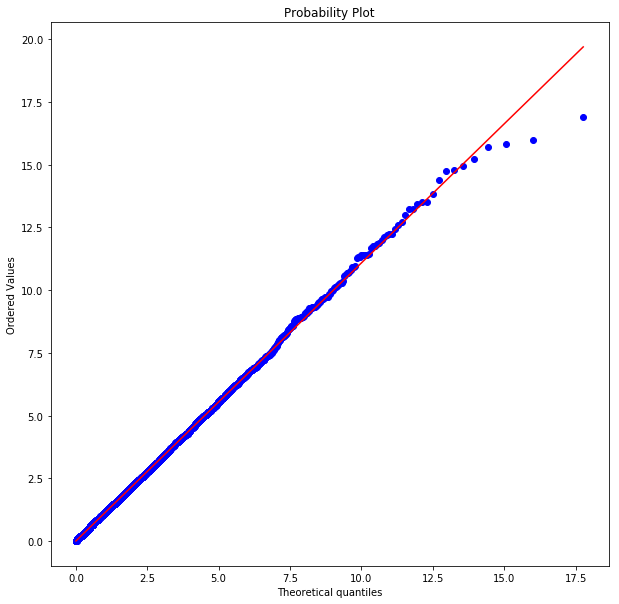

In [781]:
plt.figure(figsize=(10,10))
stats.probplot(outliersMahanalobis.d2,dist=stats.chi2(df=2), plot=plt)
plt.show()

In [793]:
np.linalg.inv(outliersMahanalobis.mcd.covariance_)

array([[  0.446,   0.007,   0.000,   0.001,   0.048,   0.005,  -0.003,   0.031,   0.045,  -0.006],
       [  0.007,   0.519,   0.000,  -0.000,   0.040,   0.002,  -0.005,   0.018,   0.033,   0.005],
       [  0.000,   0.000,   0.874,   0.019,  -0.026,   0.011,   0.003,   0.003,  -0.006,   0.018],
       [  0.001,  -0.000,   0.019,   0.945,  -0.027,   0.023,   0.017,  -0.001,  -0.002,   0.033],
       [  0.048,   0.040,  -0.026,  -0.027,   1.550,  -0.033,  -0.077,   0.130,   0.346,   0.043],
       [  0.005,   0.002,   0.011,   0.023,  -0.033,   1.517,   0.023,   0.008,   0.018,   0.018],
       [ -0.003,  -0.005,   0.003,   0.017,  -0.077,   0.023,   1.957,  -0.022,  -0.039,   0.008],
       [  0.031,   0.018,   0.003,  -0.001,   0.130,   0.008,  -0.022,   2.127,   0.127,  -0.018],
       [  0.045,   0.033,  -0.006,  -0.002,   0.346,   0.018,  -0.039,   0.127,   2.626,   0.055],
       [ -0.006,   0.005,   0.018,   0.033,   0.043,   0.018,   0.008,  -0.018,   0.055,   2.740]])

In [794]:
outliersMahanalobis.mcd.precision_

array([[  0.446,   0.007,   0.000,   0.001,   0.048,   0.005,  -0.003,   0.031,   0.045,  -0.006],
       [  0.007,   0.519,   0.000,  -0.000,   0.040,   0.002,  -0.005,   0.018,   0.033,   0.005],
       [  0.000,   0.000,   0.874,   0.019,  -0.026,   0.011,   0.003,   0.003,  -0.006,   0.018],
       [  0.001,  -0.000,   0.019,   0.945,  -0.027,   0.023,   0.017,  -0.001,  -0.002,   0.033],
       [  0.048,   0.040,  -0.026,  -0.027,   1.550,  -0.033,  -0.077,   0.130,   0.346,   0.043],
       [  0.005,   0.002,   0.011,   0.023,  -0.033,   1.517,   0.023,   0.008,   0.018,   0.018],
       [ -0.003,  -0.005,   0.003,   0.017,  -0.077,   0.023,   1.957,  -0.022,  -0.039,   0.008],
       [  0.031,   0.018,   0.003,  -0.001,   0.130,   0.008,  -0.022,   2.127,   0.127,  -0.018],
       [  0.045,   0.033,  -0.006,  -0.002,   0.346,   0.018,  -0.039,   0.127,   2.626,   0.055],
       [ -0.006,   0.005,   0.018,   0.033,   0.043,   0.018,   0.008,  -0.018,   0.055,   2.740]])